# Wstęp do uczenia maszynowego - Projekt 1
### Mikołaj Piórczyński, Michał Tomczyk, grupa 3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 

# Preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

# Model 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Feature Engineering 
from sklearn.feature_selection import VarianceThreshold, RFE

# Hyperparameters tuning 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

# Evaluation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score  
from sklearn.model_selection import cross_val_score

# XAI
import dalex as dx
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/census_income_dataset.csv')
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Braki danych 

In [3]:
# zmienne kategoryczne
df.replace('?', np.nan, inplace=True)

# zmienne numeryczne
df.replace(-100000, np.nan, inplace=True)

Zmienna `native_country` ma kategorię, która ma znacznie więcej obserwacji niż inne kategorie, więc możemy tą wartością zastąpić braki danych.

In [4]:
df['native_country'].fillna(value="United-States", inplace=True)

W przypadku zmiennych `workclass` oraz `occupation` zamieńmy braki na wartości z największym WoE.

In [5]:
df['income_level'] = df.loc[:, 'income_level'].map({'<=50K': 0, '>50K': 1})
woe_workclass = (pd.crosstab(df['workclass'],df['income_level'],normalize='columns')
                            .assign(woe = lambda x: np.log(x[1]/x[0]))).sort_values('woe',ascending=False).reset_index()
woe_occupation = (pd.crosstab(df['occupation'],df['income_level'],normalize='columns')
                            .assign(woe = lambda x: np.log(x[1]/x[0]))).sort_values('woe',ascending=False).reset_index()                            

In [6]:

df['workclass'].fillna(value = woe_workclass.iloc[0,0],inplace=True)

df['occupation'].fillna(value=woe_occupation.iloc[0,0], inplace = True)

### Dummy model

In [7]:
X = df.drop(columns=['income_level'])
y = df['income_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123, stratify=y)

dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train, y_train)

preds = dc.predict(X_test)
print(f'Accuracy for dummy model: {accuracy_score(y_test, preds)}')

Accuracy for dummy model: 0.7606715119254785


### Ewaluacja

In [8]:
def show_metrics(model, X, y):
    """
    Prints out the most important metrics
    """ 
    y_pred = model.predict(X)
    
    sns.heatmap(confusion_matrix(y, y_pred), annot=True)
    plt.show()
    
    print('Accuracy: ', accuracy_score(y, y_pred))
    print('Precision: ', precision_score(y, y_pred))
    print('Recall: ', recall_score(y, y_pred))
    print('F1 score: ', f1_score(y, y_pred))

In [34]:
def gini_train_val(model, X_train, y_train, X_val, y_val):
        
    y_pred_proba = model.predict_proba(X_train)[::,1]
    fpr, tpr, _ = roc_curve(y_train,  y_pred_proba)
    plt.plot(fpr, tpr, label='X_train')
    roc_auc = auc(fpr, tpr)
    gini_train = (2 * roc_auc) - 1
    
    y_pred_proba = model.predict_proba(X_val)[::,1]
    fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
    plt.plot(fpr, tpr, label='X_val')
    roc_auc = auc(fpr, tpr)
    gini_val = (2 * roc_auc) - 1

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    print("gini_train: %.4f" % gini_train)    
    print("gini_val: %.4f" % gini_val)

    return

### Wybór zmiennych 

Zmienna `fnlwgt` to przypisane do poszczególnych obserwacji wagi odzwierciedlającę wielkość populacji, z której próbkowane były poszczególne obserwacje. Zmienna ta nie będzie przydatna przy modelowaniu, dlatego usuwamy ją. Usuwamy też zmienne `sex` oraz `race`.

In [12]:
df.drop(columns=['fnlwgt','sex','race'], inplace=True)

### Inżynieria cech

In [13]:
def group_marital_status(df: pd.DataFrame) -> pd.DataFrame:
    df_res = df.copy()
    df_res['marital_status'] = df_res['marital_status'].replace(
        ['Married-civ-spouse', 'Married-AF-spouse'], 'Married'
    )
    
    df_res['marital_status'] = df_res['marital_status'].replace(
        ['Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-spouse-absent'], 'Living-alone'
    )
    
    return df_res  

In [14]:
def create_living_alone(df: pd.DataFrame) -> pd.DataFrame:
    df_res = df.copy()
    df_res['living_alone'] = df_res['marital_status'].replace(
        ['Married-civ-spouse', 'Married-AF-spouse'], 'Married'
    )
    
    df_res['living_alone'] = df_res['living_alone'].replace(
        ['Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-spouse-absent'], 'Living-alone'
    )
    
    return df_res  

In [15]:
def group_race(df: pd.DataFrame) -> pd.DataFrame:
    df_res = df.copy()
    df_res['marital_status'] = df_res['marital_status'].replace(
        ['Asian-Pac-Islander', 'Amer-Indian-Eskimo'], 'Other'
    )
    
    return df_res  

In [16]:
def group_education(df: pd.DataFrame) -> pd.DataFrame:
    df_res = df.copy()
    df_res['education'] = df_res['education'].replace(
            ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th'], 'Obligatory'
    )
    df_res['education'] = df_res['education'].replace(['HS-grad', 'Some-college'], 'HS-college')
    df_res['education'] = df_res['education'].replace(['Assoc-voc', 'Assoc-acdm'], 'Assoc')
    df_res['education'] = df_res['education'].replace(['Prof-school', 'Doctorate'], 'Academic')
    return df_res


In [17]:
def group_countries(df: pd.DataFrame) -> pd.DataFrame:
    df_res = df.copy()
    df_res['native_country'] = df_res['native_country'].apply(lambda x: x if x == "United-States" or x == "Mexico" else "Other")
    return df_res

In [18]:
def group_gdp(df: pd.DataFrame, gdp: pd.DataFrame) -> pd.DataFrame:
    df_res = df.copy()
    low = gdp[gdp['Country Name'] == 'Low income']['gdp'].values[0]
    low_middle = gdp[gdp['Country Name'] == 'Lower middle income']['gdp'].values[0]
    upper_middle = gdp[gdp['Country Name'] == 'Upper middle income']['gdp'].values[0]
    high = gdp[gdp['Country Name'] == 'High income']['gdp'].values[0]

    conditions = [
        (df_res["gdp"].lt(low)),
        (df_res["gdp"].ge(low) & df_res["gdp"].lt(low_middle)),
        (df_res["gdp"].ge(low_middle) & df_res["gdp"].lt(upper_middle)),
        (df_res["gdp"].ge(upper_middle) & df_res["gdp"].lt(high)),
        (df_res["gdp"].ge(high)),
    ]
    choices = ["Low income", "Lower middle income", "Middle income", "Upper middle income", "High income"]

    df_res["gdp_level"] = np.select(conditions, choices)
    return df_res

## Logistic Regression

In [20]:
gdp = pd.read_csv('data/gdp.csv')

merged = df.merge(gdp, how='left', left_on='native_country', right_on='Country Name')
merged.drop(columns=['Country Name', 'Country Code'], inplace=True)
merged.fillna(method='ffill', inplace=True)

df2 = group_gdp(merged, gdp)
df2 = group_countries(df2)
df2 = group_education(df2)
df2 = group_race(df2)
df2 = create_living_alone(df2)

X = df2.drop(columns=['income_level', 'gdp', 'education_num'])
y = df2['income_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123, stratify=y)

cat_features = ['workclass', 'marital_status', 'living_alone', 'gdp_level', 'occupation', 'relationship', 'native_country']

transformer = ColumnTransformer(
    [
        ('log', FunctionTransformer(np.log1p), ['capital_loss']),
        ('std_scaler', StandardScaler(), ['age', 'capital_loss']),
        ('min_max_scaler', MinMaxScaler(), ['capital_gain', 'hours_per_week']),
        ('ordinal', OrdinalEncoder(), ['education']),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'
)

lr_model = LogisticRegression(random_state=123, n_jobs=-1)

kfolds = 5
split = KFold(n_splits=kfolds, shuffle=True, random_state=123)
pipe =  Pipeline(
    [
        ('transformer', transformer),
        ('model', lr_model)
    ]
)
cv_results = cross_val_score(pipe, X_train, y_train, cv=split, scoring='accuracy', n_jobs=-1)
print(f'xgb_model cross validation accuracy score: {cv_results.mean()} +/- {cv_results.std()} min: {cv_results.min()} max: {cv_results.max()}')

xgb_model cross validation accuracy score: 0.8401709876182339 +/- 0.0019902436836335426 min: 0.8382597568777991 max: 0.8426103646833013


In [41]:
lr_model = LogisticRegression(random_state=123, n_jobs=-1, penalty='l1', C=0.001, solver='liblinear')
best_random = Pipeline(
    [
        ('transformer', transformer),
        ('model', lr_model)
    ]
)
best_random.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['capital_loss']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital_loss']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['capital_gain',
                                                   'hours_per_week']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('one_hot_encod

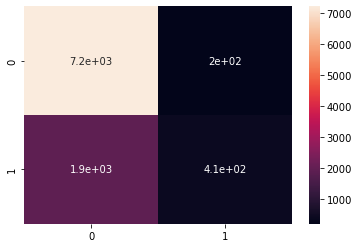

Accuracy:  0.7820657180878289
Precision:  0.6710310965630114
Recall:  0.17536355859709152
F1 score:  0.27806035944387925


In [42]:
show_metrics(best_random, X_test, y_test)

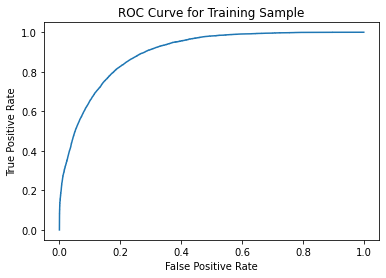

gini_train: 0.7941


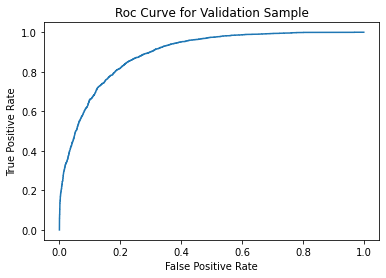

gini_val: 0.7863


In [24]:
gini_train_val(best_random, X_train, y_train, X_test, y_test)

## XGB

In [28]:
gdp = pd.read_csv('data/gdp.csv')

merged = df.merge(gdp, how='left', left_on='native_country', right_on='Country Name')
merged.drop(columns=['Country Name', 'Country Code'], inplace=True)
merged.fillna(method='ffill', inplace=True)

df2 = group_gdp(merged, gdp)
df2 = group_countries(df2)
df2 = group_education(df2)
df2 = group_race(df2)
df2 = create_living_alone(df2)

X = df2.drop(columns=['income_level', 'gdp', 'education_num'])
y = df2['income_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123, stratify=y)

cat_features = ['workclass', 'marital_status', 'living_alone', 'gdp_level', 'occupation', 'relationship', 'native_country']

transformer = ColumnTransformer(
    [
        ('log', FunctionTransformer(np.log1p), ['capital_loss']),
        ('std_scaler', StandardScaler(), ['age', 'capital_loss']),
        ('min_max_scaler', MinMaxScaler(), ['capital_gain', 'hours_per_week']),
        ('ordinal', OrdinalEncoder(), ['education']),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough'
)

xgb_model = XGBClassifier(random_state=123, n_jobs=-1)

kfolds = 5
split = KFold(n_splits=kfolds, shuffle=True, random_state=123)
pipe = Pipeline(
    [
        ('transformer', transformer),
        ('model', xgb_model)
    ]
)

cv_results = cross_val_score(pipe, X_train, y_train, cv=split, scoring='accuracy', n_jobs=-1)
print(f'xgb_model cross validation accuracy score: {cv_results.mean()} +/- {cv_results.std()} min: {cv_results.min()} max: {cv_results.max()}')

xgb_model cross validation accuracy score: 0.8723671425911561 +/- 0.0018298461141139921 min: 0.8698656429942418 max: 0.8749840051183622


In [37]:
xgb_model = XGBClassifier(random_state=123, n_jobs=-1, n_estimators=200, max_depth=5, learning_rate=0.3, gamma=5, subsample=0.8)
best_random = Pipeline(
    [
        ('transformer', transformer),
        ('model', xgb_model)
    ]
)
best_random.fit(X_train, y_train)

[00:09:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['capital_loss']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital_loss']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['capital_gain',
                                                   'hours_per_week']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('one_hot_encod

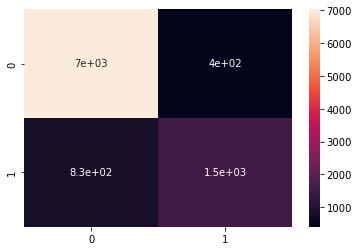

Accuracy:  0.8742962432183438
Precision:  0.7911857292759706
Recall:  0.6449957228400343
F1 score:  0.710650329877474


In [38]:
show_metrics(best_random, X_test, y_test)

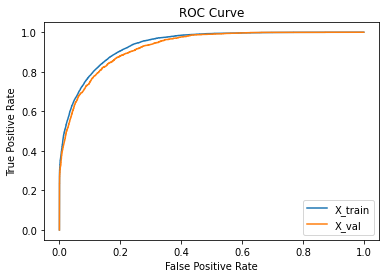

gini_train: 0.8748
gini_val: 0.8528


In [39]:
gini_train_val(best_random, X_train, y_train, X_test, y_test)